In [9]:
feature_names_2jets_GG = ['njets', 'met', 'DeltaEta_e_m', 'empt', 'DeltaPhi_em_met', 'j1pt', 'j1Eta', 'DeltaEta_j1_j2', 'j1_j2_mass', 'DeltaEta_j1_em', 'Ht_had', 'Rpt', 'j2pt', 'pt_cen_Deltapt']
feature_names_2jets_VBF = ['Zeppenfeld_DeltaEta', 'met', 'DeltaEta_e_m', 'empt', 'j1pt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'Ht_had', 'Rpt', 'j2pt', 'pt_cen_Deltapt']

features_lists = [feature_names_2jets_GG, feature_names_2jets_VBF]
ncats = 2

In [46]:
features_map = {
    "mva": ['BDT Discriminator', 100, 0, 1],#30
    "e_m_Mass": ['$m_{e\mu}$ [GeV]', 50, 110, 160]
}
features_map_vbf = {
    "mva": ['BDT Discriminator', 100, 0, 1],#25
    "e_m_Mass": ['$m_{e\mu}$ [GeV]', 50, 110, 160]
}

In [66]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2016preVFP', '2017', '2016postVFP','2018']
var_dict = {}
for year in years:
    print(f'Processing {year}')
    for subsample in ['signal','diboson','tt','data','st','dy','wjets','higgs','ewk']:#,'others'
        result = load(f"../results/{year}/makeDF/output_eleSF_{subsample}.coffea") #testv9
        if isinstance(result,tuple):
            result = result[0]
        for varName in result:
            if varName in var_dict:
                var_dict[varName] = np.append(var_dict[varName],result[varName].value)
            else:
                var_dict[varName] = result[varName].value
df = pd.DataFrame(var_dict).drop(['is2016preVFP', 'is2016postVFP', 'is2017', 'is2018'], axis=1)
df['j1_j2_mass'].replace(0, np.nan, inplace=True)
df['j1pt'].replace(0, np.nan, inplace=True)
df['j2pt'].replace(0, np.nan, inplace=True)


Processing 2016preVFP
Processing 2017
Processing 2016postVFP
Processing 2018


In [67]:
df = df[(df.mtrigger==1)]

In [68]:
df_clean = df[(df['opp_charge']==1) & (df['e_m_Mass']>110) & (df['e_m_Mass']<160)]
data_cuts_os = [df_clean[df_clean['isVBFcat']==0], df_clean[df_clean['isVBFcat']==1]]

In [69]:
df_clean_ss = df[(df['opp_charge']!=1) & (df['e_m_Mass']>110) & (df['e_m_Mass']<160)]
data_cuts_ss = [df_clean_ss[df_clean_ss['isVBFcat']==0], df_clean_ss[df_clean_ss['isVBFcat']==1]]

In [70]:
#Load and predict from model
import xgboost as xgb
model_names = ["results/model_GG.json", "results/model_VBF.json"]
for i in range(ncats):
    print(i)
    model_out_file = model_names[i]
    model_load = xgb.XGBClassifier()
    model_load.load_model(model_out_file)
    data_cuts_os[i]['mva'] = model_load.predict_proba(data_cuts_os[i][features_lists[i]])[:,1]
    data_cuts_ss[i]['mva'] = model_load.predict_proba(data_cuts_ss[i][features_lists[i]])[:,1]

0


/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_3801112/857725512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cuts_os[i]['mva'] = model_load.predict_proba(data_cuts_os[i][features_lists[i]])[:,1]
/tmp/ipykernel_3801112/857725512.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

1


In [71]:
dict_of_hists = [{}, {}]

from coffea import hist

dataset_axis = hist.Cat("dataset", "samples")
for i in range(ncats):
    if i==1:
        features_map_ = features_map_vbf
    else:
        features_map_ = features_map
    for var_ in ['mva']:
        dict_of_hists[i][var_] = hist.Hist("Events", dataset_axis, hist.Bin(var_, features_map_[var_][0], features_map_[var_][1], features_map_[var_][2], features_map_[var_][3]))

    dict_of_hists[i]['e_m_Mass'] = hist.Hist("Events", dataset_axis, hist.Bin('mva', features_map_['mva'][0], features_map_['mva'][1], features_map_['mva'][2], features_map_['mva'][3]), hist.Bin('e_m_Mass', features_map_['e_m_Mass'][0], features_map_['e_m_Mass'][1], features_map_['e_m_Mass'][2], features_map_['e_m_Mass'][3]))


#!ln -s /afs/crc.nd.edu/user/k/kho2/Flavour-Violating-Coffea/find_samples.py find_samples.py
#import find_samples
samples = ['dataE', 'GluGlu_LFV_HToEMu_M125', 'VBF_LFV_HToEMu_M125', 'TTTo2L2Nu', 'GluGlu_LFV_HToEMu_M120', 'VBF_LFV_HToEMu_M120', 'GluGlu_LFV_HToEMu_M130', 'VBF_LFV_HToEMu_M130', 'ZZ_TuneCP5', 'WZ_TuneCP5', 'WW_TuneCP5', 'DYJetsToLL_M-50', 'DYJetsToLL_M-10to50', 'WGToLNuG_TuneCP5', 'TTToSemiLeptonic', 'TTToHadronic', 'ST_tW_antitop_5f_inclusiveDecays', 'ST_tW_top_5f_inclusiveDecays', 'ST_t-channel_antitop_4f_InclusiveDecays', 'ST_t-channel_top_4f_InclusiveDecays', 'EWKZ2Jets_ZToLL', 'EWKZ2Jets_ZToNuNu', 'EWKWMinus2Jets', 'EWKWPlus2Jets', 'GluGluHToTauTau', 'VBFHToTauTau', 'WminusHToTauTau', 'WplusHToTauTau', 'GluGluHToWWTo2L2Nu', 'VBFHToWWTo2L2Nu', 'ZHToTauTau', 'WJetsToLNu_TuneCP5', 'GluGlu_LFV_HToEMu_M110', 'VBF_LFV_HToEMu_M110', 'GluGlu_LFV_HToEMu_M140', 'VBF_LFV_HToEMu_M140', 'GluGlu_LFV_HToEMu_M150', 'VBF_LFV_HToEMu_M150', 'GluGlu_LFV_HToEMu_M160', 'VBF_LFV_HToEMu_M160', 'data']

sample_group = []

for i in samples:
    sample_group_name = ''
    if "TT" in i:
        sample_group_name = r'$t\bar{t}$'
    elif "ST" in i:
        sample_group_name = r't+Jets'
    elif "LFV" in i:
        sample_group_name = r'$H\rightarrow e\mu$ (BR=1%)'
    elif "HTo" in i:
        sample_group_name = 'SM Higgs'
    elif "ZZ" in i or "WZ" in i  or "WW" in i:
        sample_group_name = "Diboson"
    elif "DY" in i:
        sample_group_name = "DY+Jets"
    elif "JetsToLNu" in i or "WG" in i:
        sample_group_name = "W+Jets"
    elif "EWK" in i:
        sample_group_name = "EWK W/Z"
    elif "data" in i:
        sample_group_name = "Data"
    sample_group.append(sample_group_name)
sample_group = np.array(sample_group)

for i in range(ncats):
    data_cuts_os[i]['sample_name'] = sample_group.take(data_cuts_os[i]['sample'].to_numpy().astype(int))
    data_cuts_ss[i]['sample_name'] = sample_group.take(data_cuts_ss[i]['sample'].to_numpy().astype(int))

subset_os, subset_ss = {}, {}
for groupName in sample_group:
    subset_os[groupName], subset_ss[groupName] = [], []
    for i in range(ncats):
        subset_os[groupName].append(data_cuts_os[i][data_cuts_os[i]['sample_name']==groupName])
        subset_ss[groupName].append(data_cuts_ss[i][data_cuts_ss[i]['sample_name']==groupName])

for i in range(ncats):
    print(f'Plotting {i} jets Variables')
    for var_ in ['mva']:
        for groupName in list(dict.fromkeys(sample_group)):
            arg = {var_: subset_os[groupName][i][var_].to_numpy(), 'dataset': groupName, 'weight': subset_os[groupName][i]['weight'].to_numpy()}
            dict_of_hists[i][var_].fill(**arg)           
            if groupName=='Data':
                arg = {var_: subset_ss[groupName][i][var_].to_numpy(), 'dataset': 'QCD', 'weight': subset_ss[groupName][i]['weight'].to_numpy()}
                dict_of_hists[i][var_].fill(**arg)
            elif not 'BR' in groupName:
                arg = {var_: subset_ss[groupName][i][var_].to_numpy(), 'dataset': 'QCD', 'weight': 0-subset_ss[groupName][i]['weight'].to_numpy()}
                dict_of_hists[i][var_].fill(**arg)
    for groupName in list(dict.fromkeys(sample_group)):
        arg = {'mva': subset_os[groupName][i]['mva'].to_numpy(), 'e_m_Mass': subset_os[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': groupName, 'weight': subset_os[groupName][i]['weight'].to_numpy()}
        dict_of_hists[i]['e_m_Mass'].fill(**arg)           
        if groupName=='Data':
            arg = {'mva': subset_ss[groupName][i]['mva'].to_numpy(), 'e_m_Mass': subset_ss[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': 'QCD', 'weight': subset_ss[groupName][i]['weight'].to_numpy()}
            dict_of_hists[i]['e_m_Mass'].fill(**arg)
        elif not 'BR' in groupName:
            arg = {'mva': subset_ss[groupName][i]['mva'].to_numpy(), 'e_m_Mass': subset_ss[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': 'QCD', 'weight': 0-subset_ss[groupName][i]['weight'].to_numpy()}
            dict_of_hists[i]['e_m_Mass'].fill(**arg)


/tmp/ipykernel_3801112/3723735595.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cuts_os[i]['sample_name'] = sample_group.take(data_cuts_os[i]['sample'].to_numpy().astype(int))
/tmp/ipykernel_3801112/3723735595.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cuts_ss[i]['sample_name'] = sample_group.take(data_cuts_ss[i]['sample'].to_numpy().astype(int))


Plotting 0 jets Variables
Plotting 1 jets Variables


In [72]:
for dict_of_hist, feature_names in zip(dict_of_hists, features_lists): 
    for var_ in ['mva', 'e_m_Mass']:
        histo = dict_of_hist[var_]
        
        signal_scale = 1 if var_=='mva' else 0.05
        scales = {
            r'$H\rightarrow e\mu$ (BR=1%)': signal_scale,
        }
        histo.scale(scales, axis='dataset')
        #r'$t\bar{t}$':1.0711607711238926

In [73]:
list_of_bkg_oder = [r'$t\bar{t}$', 't+Jets', 'SM Higgs', "DY+Jets", "EWK W/Z", "Diboson", "W+Jets", "QCD"]

In [ ]:
from coffea.util import save, load
from coffea import hist
import math
import mplhep
import matplotlib.transforms as transforms

%matplotlib inline

catlabels = ['ggH cat', 'VBF cat']
catlabels2 = ['gg', 'vbf']

list_of_bkg = [r'$t\bar{t}$', 't+Jets', 'SM Higgs', "DY+Jets", "EWK W/Z", "Diboson", "W+Jets"]#, "QCD"]
list_of_label = ['QCD', 'SM Higgs', 'EWK W/Z', 'W+Jets', 'DY+Jets', 't+Jets', '$t\\bar{t}$', 'Diboson', 'Cross Sec. $\\bigoplus$ Stat. Unc.', '$H\\rightarrow e\\mu$ (BR=1.0%)', 'Data']
colors_bkg = ['#8c564b', '#e377c2', '#d62728', '#bcbd22',  '#17becf', '#7f7f7f', '#2ca02c', '#9467bd'] #['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
bdtcuts = [[0.49,0.73,0.81],[0.75,0.89]]
bdtcuts2 = [[0,0.49,0.73,0.81,1],[0,0.75,0.89,1]]
# dict_of_hist, feature_names, catlabel = dict_of_hists[2], features_lists[2], catlabels[2]
# if True:
for dict_of_hist, catlabel, catlabel2, bdtcut, bdtcut2 in zip(dict_of_hists, catlabels, catlabels2, bdtcuts, bdtcuts2):
    for var_ in ['mva']:
        histo = dict_of_hist[var_] 
        signal_scale = 1

        data = histo["Data"] 
        bkg = histo[list_of_bkg]
        signal = histo[r'$H\rightarrow e\mu$ (BR=1%)']
        
        qcd = histo['QCD'].copy()
        (k, v), = histo['QCD']._sumw.items()
        qcd._sumw2[k][qcd._sumw[k]<0] = 0
        qcd._sumw[k][qcd._sumw[k]<0] = 0
        bkg.add(qcd)
        for i in range(len(bdtcut2)-1):
            print(round(qcd._sumw[k][int(bdtcut2[i]*100+1):int(bdtcut2[i+1]*100+1)].sum()))

        import matplotlib.pyplot as plt
        plt.style.use(mplhep.style.CMS)

        plt.rcParams.update({
            'font.size': 30,
            'axes.titlesize': 24,
            'axes.labelsize': 28,
            'xtick.labelsize': 20,
            'ytick.labelsize': 20,
        })
        
        plt.rcParams.update({'lines.linewidth': 3})

        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(12,12),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.08)
        
        list_of_bkg_oder2 = sorted(list_of_bkg_oder, key=lambda x: histo[x].values()[(x,)].sum(), reverse=True)

        fill_opts = {
            'edgecolor': (0,0,0,0.3),
            'color': [c for _, c in sorted(zip(list_of_bkg_oder, colors_bkg), key=lambda pair: list_of_bkg_oder2.index(pair[0]))]
            #'alpha': 0.8
        }
        error_opts = {
            'label': 'Stat. Unc.',
            'hatch': '///',
            'facecolor': 'none',
            'edgecolor': (0,0,0,.5),
            'linewidth': 0
        }
        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        hist.plot1d(
            bkg,
            overlay="dataset",
            ax=ax,
            clear=False,
            stack=True,
            line_opts=None,
            fill_opts=fill_opts,
            order=list_of_bkg_oder2
            #error_opts=error_opts
        )

        hist.plot1d(
            signal,
            overlay="dataset",
            ax=ax,
            clear=False,
            line_opts={'linewidth': 3.0},
            error_opts={}
        )
        
        hist.plot1d(
            data,
            overlay="dataset",
            ax=ax,
            clear=False,
            error_opts=data_err_opts
        )
        
        v1 = np.zeros(len(bkg["t+Jets"].to_hist().axes.edges[1][0])+2)
        v2 = np.zeros(len(bkg["t+Jets"].to_hist().axes.edges[1][0])+2)
        (k, v3), = data._sumw.items()
        for listofbkg in list_of_bkg+['QCD']:
            (k, v), = bkg[listofbkg]._sumw.items()
            (k_2, v_2), = bkg[listofbkg]._sumw2.items()
            v2+=v
            v1+=np.sqrt(v_2)
            #v1+=v*0.02
            if listofbkg==r'$t\bar{t}$':
                v1+=v*0.06
            if listofbkg=='t+Jets':
                v1+=v*0.05
            elif listofbkg=="DY+Jets":
                v1+=v*0.04
            elif listofbkg=="Diboson":
                v1+=v*0.05
            elif listofbkg=="EWK W/Z":
                v1+=v*0.04
            elif listofbkg=="W+Jets":
                v1+=v*0.10
            elif listofbkg=="QCD":
                v1+=v*0.30

        ax.stairs(
            edges=bkg["t+Jets"].to_hist().axes.edges[1][0],
            baseline=v2[1:-2] - v1[1:-2],
            values=v2[1:-2] + v1[1:-2],
            hatch="///",
            label=r"Cross Sec. $\bigoplus$ Stat. Unc.",
            facecolor="none",
            linewidth=0,
            edgecolor=(0,0,0,.5)
        )

        ax.autoscale(axis='x', tight=True)
        if var_=='mva1':
            ax.set_yscale('log')
            #if catlabel=='VBF cat':
            #    ax.set_ylim(10**(math.log10(min([i for i in data.sum("dataset").values()[()] if i!=0]))-.2), 10**(math.log10(max(data.sum("dataset").values()[()]))+1.5))
            #else:
            #     ax.set_ylim(10**(math.log10(min([i for i in data.sum("dataset").values()[()] if i!=0]))-1), 10**(math.log10(max(data.sum("dataset").values()[()]))+1.5))
        else:
            ax.set_ylim(0, max(data.sum("dataset").values()[()])*1.5)
#        ax.set_ylim(0, max(data.sum("dataset").values()[()])*2)
        ax.set_xlabel(None)
        trans = transforms.blended_transform_factory(ax.get_xaxis_transform(), ax.transAxes)
        if var_=='mva':
            for i,cut in enumerate(bdtcut):
                ax.axvline(x=cut, ymax=0.7, linestyle='--', color='black')
                if catlabel2=='vbf':
                    j = i - 1
                else:
                    j = i
                if i == 0:
                    if catlabel2=='vbf': continue
                    ax.text(bdtcut[j]/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='xx-small', transform=trans, rotation='vertical')
                else:
                    ax.text(bdtcut[j-1]+(bdtcut[j]-bdtcut[j-1])/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='xx-small', transform=trans, rotation='vertical')

            ax.text(bdtcut[i]+(1-bdtcut[i])/2, 0.63, f'{catlabel2}cat{j+1}', horizontalalignment='center', size='xx-small', transform=trans, rotation='vertical')

        
            if catlabel2=='vbf':
                ax.axvspan(0, 0.75, ymax=0.7, alpha=0.1, color='black')

        label_list = []
        for t in ax.get_legend_handles_labels():
            label_list.append(t)
        new_label_list = []
        for txt in label_list[1]:
            if txt[0] == '0':
                txt = str(txt)[:4]
            if txt==r'$H\rightarrow e\mu$ (BR=1%)':
                new_label_list.append(r'$H\rightarrow e\mu$ (BR={:.1f}%)'.format(signal_scale))
            else:
                new_label_list.append(txt)
        label_list[1] = new_label_list
        label_list[1], label_list[0] = zip(*sorted(zip(label_list[1], label_list[0]), key=lambda t: list_of_label.index(t[0])))
        
        leg = ax.legend(title_fontsize=16, title=catlabel+' \n$m_{e\mu} \in (110, 160) \ GeV$', fontsize=16, ncol=4, columnspacing=1, labelspacing=0.25, loc=9, handles=label_list[0], labels=label_list[1])
        #leg = ax.legend(title_fontsize=16, title=catlabel+' \nData/Bkg: $m_{e\mu} \in (110, 115) \cup (135, 160)\ GeV$; Signal: $m_{e\mu} \in (110, 160)\ GeV$', fontsize=16, ncol=4, columnspacing=1, labelspacing=0.25, loc=9, handles=label_list[0], labels=label_list[1])
        leg._legend_box.align = "left"
         
#         ax.annotate('GG cat, 0 jet \nData/Bkg: $m_{e\mu} \in (110, 115) \cup (135, 160)\ GeV$\nSignal: $m_{e\mu} \in (110, 160)\ GeV$', xy=(0.05,0.05), xycoords='axes fraction',
#              fontsize=14, weight='bold')
        hist.plotratio(
            num=data.sum("dataset"),
            denom=bkg.sum("dataset"),
            ax=rax,
            error_opts=data_err_opts,
            #denom_fill_opts={},
            guide_opts={},
            unc='num'
        )
        rax.stairs(
            edges=bkg["t+Jets"].to_hist().axes.edges[1][0],
            baseline=1 - v3[1:-2]*v1[1:-2]/(v2[1:-2]*v2[1:-2]),
            values=1 +  v3[1:-2]*v1[1:-2]/(v2[1:-2]*v2[1:-2]),
            hatch="///",
            label="Stat. unc.",
            facecolor="none",
            linewidth=0,
            edgecolor=(0,0,0,.5)
        )

    #         from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
    #         rax.xaxis.set_minor_locator(AutoMinorLocator()) #rax.minorticks_on()
        if catlabel=='VBF cat':
            rax.set_ylim(0, 2)
        else:
            rax.set_ylim(0.5, 1.5)
        rax.set_ylabel("Data/Bkg", loc='center')

        lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
        #fig.savefig(f'plots/MCData/{var_}_{catlabel2}.png')

1511
758
240
184


/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=mva) instance at 0x7f679e923340>: requested stop 0.49 between bin boundaries, no interpolation is performed
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=mva) instance at 0x7f679e923340>: requested start 0.49 between bin boundaries, no interpolation is performed
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=mva) instance at 0x7f679e923340>: requested stop 0.73 between bin boundaries, no interpolation is performed
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning:

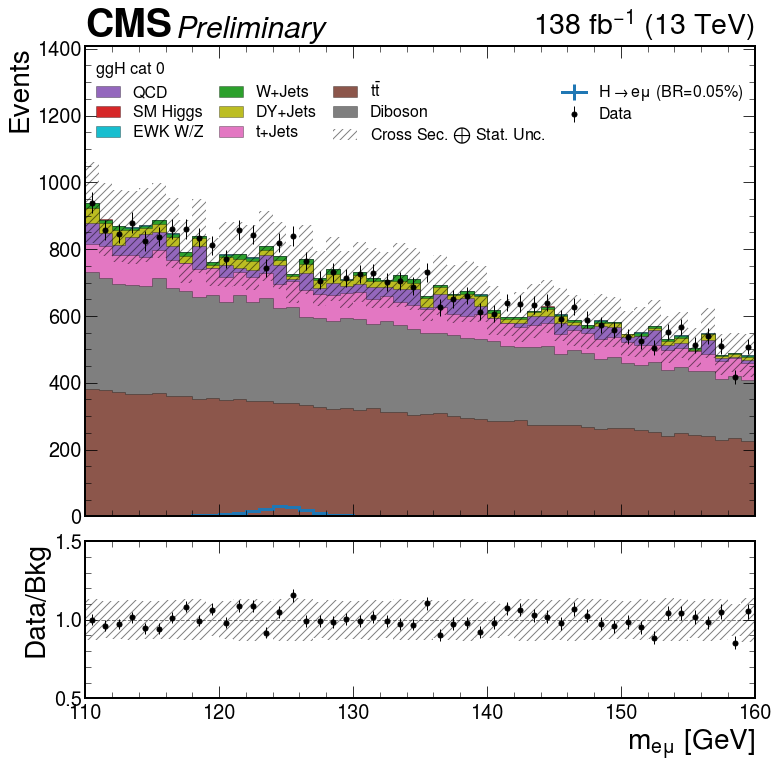

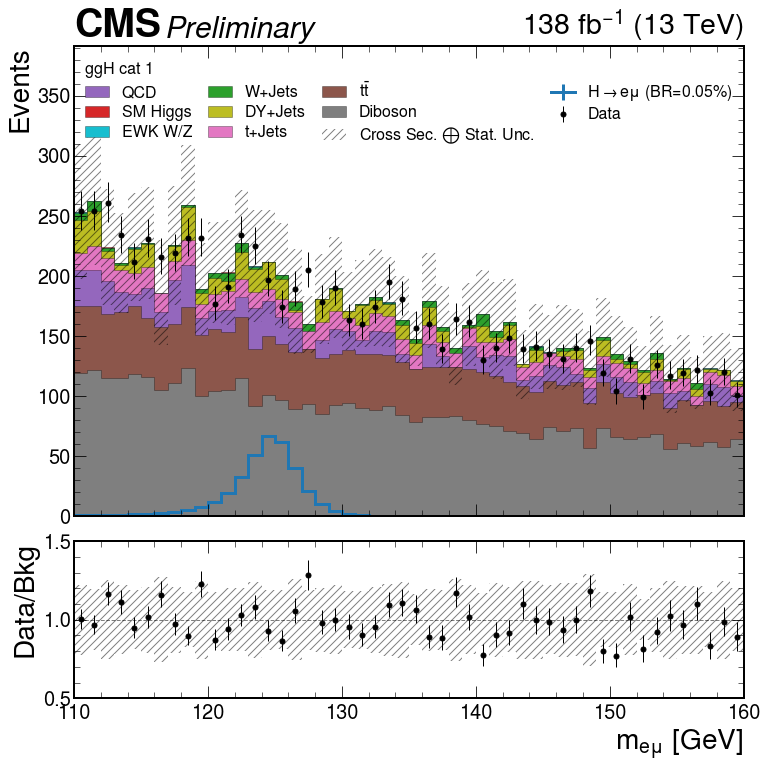

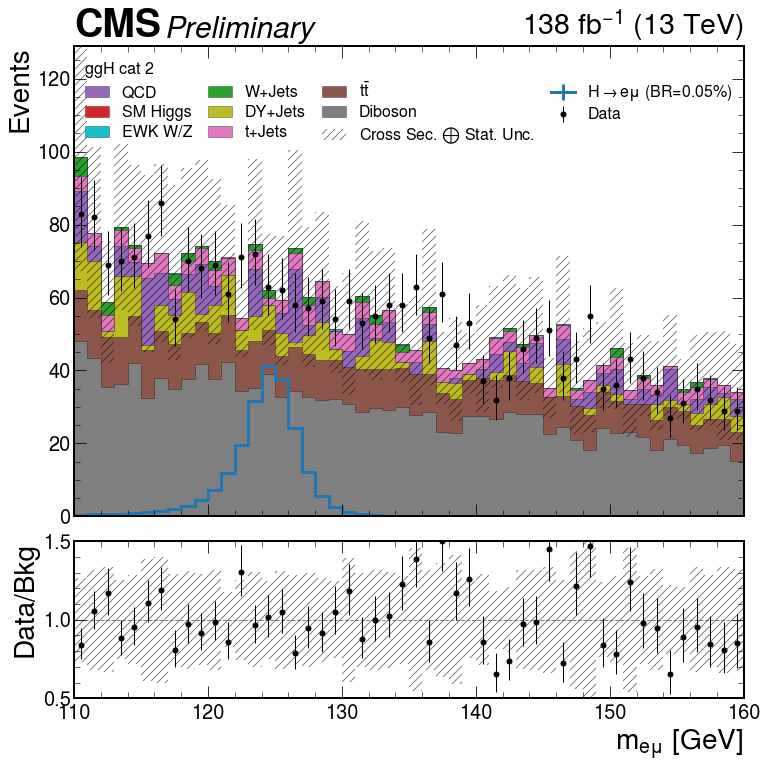

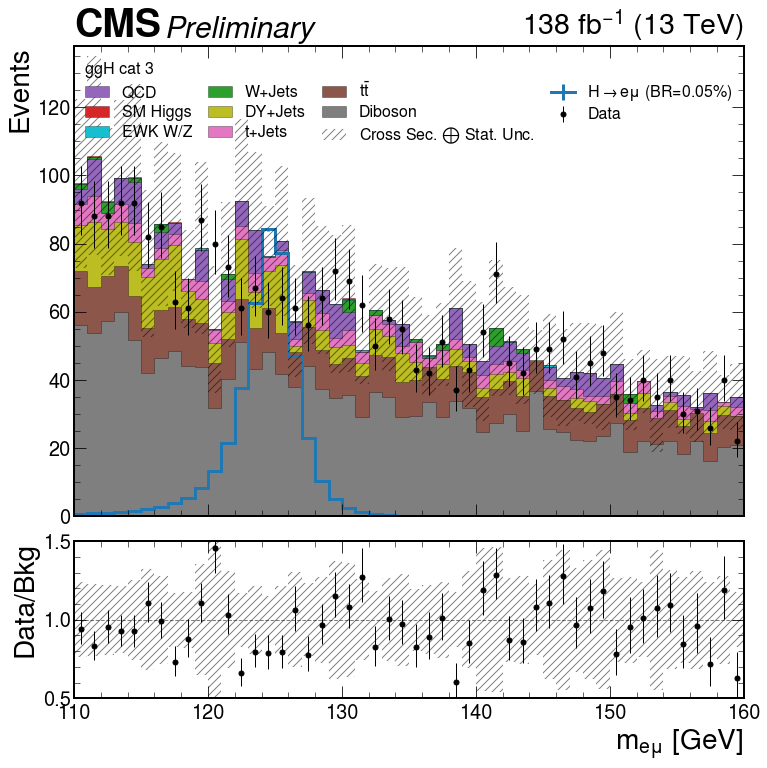

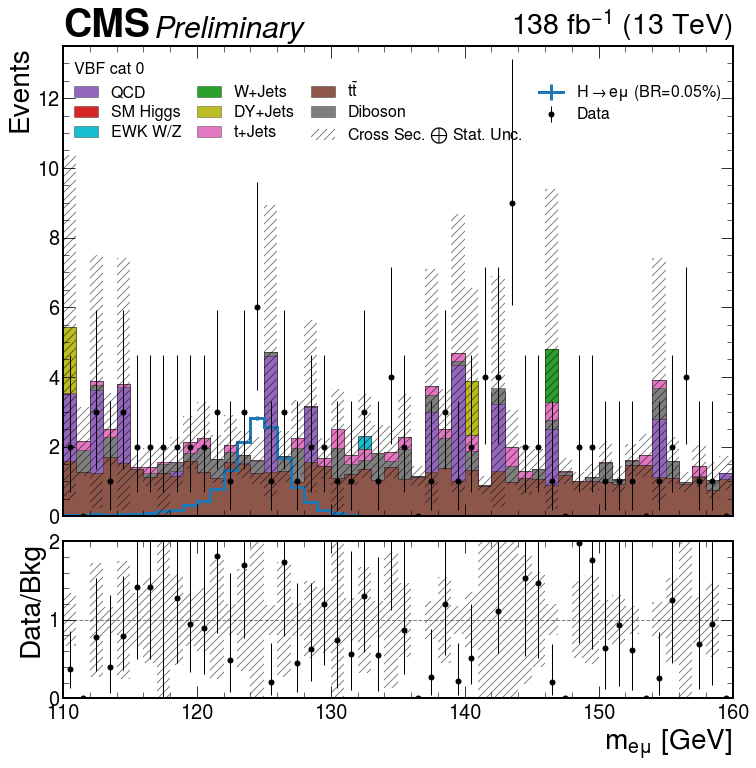

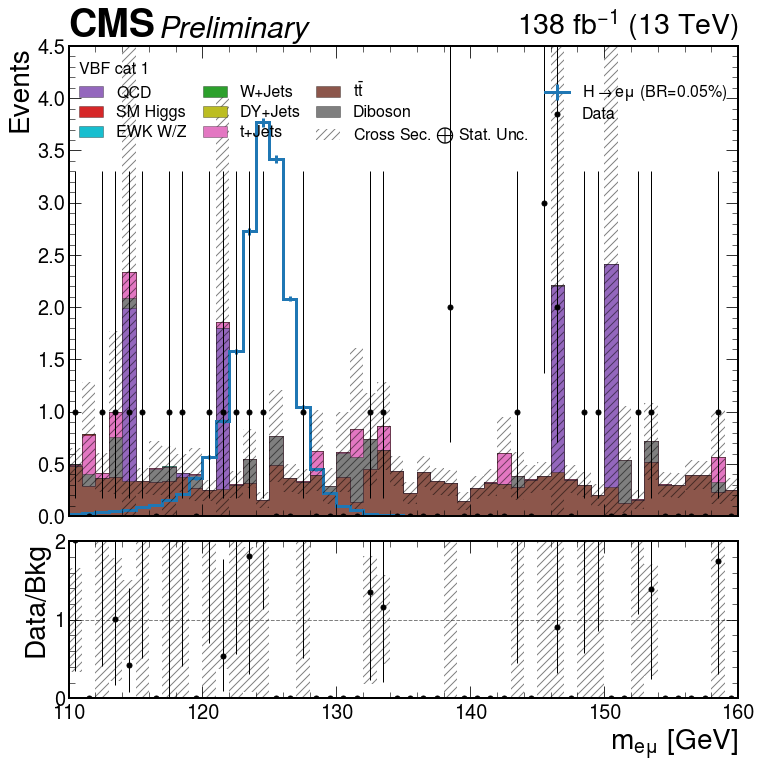

In [24]:
from coffea.util import save, load
from coffea import hist
import math
import mplhep
import matplotlib.transforms as transforms

%matplotlib inline

catlabels = ['ggH cat', 'VBF cat']
catlabels2 = ['gg', 'vbf']

list_of_bkg = [r'$t\bar{t}$', 't+Jets', 'SM Higgs', "DY+Jets", "EWK W/Z", "Diboson", "W+Jets"]#, "QCD"]
list_of_label = ['QCD', 'SM Higgs', 'EWK W/Z', 'W+Jets', 'DY+Jets', 't+Jets', '$t\\bar{t}$', 'Diboson', 'Cross Sec. $\\bigoplus$ Stat. Unc.', '$H\\rightarrow e\\mu$ (BR=0.05%)', 'Data']
colors_bkg = ['#8c564b', '#e377c2', '#d62728', '#bcbd22',  '#17becf', '#7f7f7f', '#2ca02c', '#9467bd'] #['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
bdtcuts = [[0,0.49,0.73,0.81,1],[0.75,0.89,1]]
# dict_of_hist, feature_names, catlabel = dict_of_hists[2], features_lists[2], catlabels[2]
# if True:
for dict_of_hist, catlabel, catlabel2, bdtcut in zip(dict_of_hists, catlabels, catlabels2, bdtcuts):
    for var_ in ['e_m_Mass']:
        for j, cut in enumerate(bdtcut[:-1]):
            histo = dict_of_hist[var_] .integrate("mva", slice(bdtcut[j], bdtcut[j+1]))
            signal_scale = 1

            data = histo["Data"] 
            bkg = histo[list_of_bkg]
            signal = histo[r'$H\rightarrow e\mu$ (BR=1%)']

            qcd = histo['QCD'].copy()
            (k, v), = histo['QCD']._sumw.items()
            qcd._sumw2[k][qcd._sumw[k]<0] = 0
            qcd._sumw[k][qcd._sumw[k]<0] = 0
            bkg.add(qcd)

            import matplotlib.pyplot as plt
            plt.style.use(mplhep.style.CMS)

            plt.rcParams.update({
                'font.size': 30,
                'axes.titlesize': 24,
                'axes.labelsize': 28,
                'xtick.labelsize': 20,
                'ytick.labelsize': 20,
            })

            plt.rcParams.update({'lines.linewidth': 3})

            fig, (ax, rax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(12,12),
                gridspec_kw={"height_ratios": (3, 1)},
                sharex=True
            )
            fig.subplots_adjust(hspace=.08)

            list_of_bkg_oder2 = sorted(list_of_bkg_oder, key=lambda x: histo[x].values()[(x,)].sum(), reverse=True)

            fill_opts = {
                'edgecolor': (0,0,0,0.3),
                'color': [c for _, c in sorted(zip(list_of_bkg_oder, colors_bkg), key=lambda pair: list_of_bkg_oder2.index(pair[0]))]
                #'alpha': 0.8
            }
            error_opts = {
                'label': 'Stat. Unc.',
                'hatch': '///',
                'facecolor': 'none',
                'edgecolor': (0,0,0,.5),
                'linewidth': 0
            }
            data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'color': 'k',
                'elinewidth': 1,
            }

            hist.plot1d(
                bkg,
                overlay="dataset",
                ax=ax,
                clear=False,
                stack=True,
                line_opts=None,
                fill_opts=fill_opts,
                order=list_of_bkg_oder2
                #error_opts=error_opts
            )

            hist.plot1d(
                signal,
                overlay="dataset",
                ax=ax,
                clear=False,
                line_opts={'linewidth': 3.0},
                error_opts={}
            )

            hist.plot1d(
                data,
                overlay="dataset",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
            )

            v1 = np.zeros(len(bkg["t+Jets"].to_hist().axes.edges[1][0])+2)
            v2 = np.zeros(len(bkg["t+Jets"].to_hist().axes.edges[1][0])+2)
            (k, v3), = data._sumw.items()
            for listofbkg in list_of_bkg+['QCD']:
                (k, v), = bkg[listofbkg]._sumw.items()
                (k_2, v_2), = bkg[listofbkg]._sumw2.items()
                v2+=v
                v1+=np.sqrt(v_2)
                #v1+=v*0.02
                if listofbkg==r'$t\bar{t}$':
                    v1+=v*0.06
                if listofbkg=='t+Jets':
                    v1+=v*0.05
                elif listofbkg=="DY+Jets":
                    v1+=v*0.04
                elif listofbkg=="Diboson":
                    v1+=v*0.05
                elif listofbkg=="EWK W/Z":
                    v1+=v*0.04
                elif listofbkg=="W+Jets":
                    v1+=v*0.10
                elif listofbkg=="QCD":
                    v1+=v*0.30

            ax.stairs(
                edges=bkg["t+Jets"].to_hist().axes.edges[1][0],
                baseline=v2[1:-2] - v1[1:-2],
                values=v2[1:-2] + v1[1:-2],
                hatch="///",
                label=r"Cross Sec. $\bigoplus$ Stat. Unc.",
                facecolor="none",
                linewidth=0,
                edgecolor=(0,0,0,.5)
            )

            ax.autoscale(axis='x', tight=True)
            if var_=='mva':
                ax.set_yscale('log')
                if catlabel=='VBF cat':
                    ax.set_ylim(10**(math.log10(min([i for i in data.sum("dataset").values()[()] if i!=0]))-.2), 10**(math.log10(max(data.sum("dataset").values()[()]))+1.5))
                else:
                     ax.set_ylim(10**(math.log10(min([i for i in data.sum("dataset").values()[()] if i!=0]))-1), 10**(math.log10(max(data.sum("dataset").values()[()]))+1.5))
            else:
                ax.set_ylim(0, max(data.sum("dataset").values()[()])*1.5)
                
            ax.set_xlabel(None)
            trans = transforms.blended_transform_factory(ax.get_xaxis_transform(), ax.transAxes)

            label_list = []
            for t in ax.get_legend_handles_labels():
                label_list.append(t)
            
            new_label_list = []
            for txt in label_list[1]:
                if txt[0] == '0':
                    txt = str(txt)[:4]
                elif txt==r'$H\rightarrow e\mu$ (BR=1%)':
                    new_label_list.append(r'$H\rightarrow e\mu$ (BR={:.2f}%)'.format(0.05))
                else:
                    new_label_list.append(txt)

            label_list[1] = new_label_list
            label_list[1], label_list[0] = zip(*sorted(zip(label_list[1], label_list[0]), key=lambda t: list_of_label.index(t[0])))

            leg = ax.legend(title_fontsize=16, title=catlabel+f' {j}', fontsize=16, ncol=4, columnspacing=1, labelspacing=0.25, loc=9, handles=label_list[0], labels=label_list[1])
            #leg = ax.legend(title_fontsize=16, title=catlabel+' \nData/Bkg: $m_{e\mu} \in (110, 115) \cup (135, 160)\ GeV$; Signal: $m_{e\mu} \in (110, 160)\ GeV$', fontsize=16, ncol=4, columnspacing=1, labelspacing=0.25, loc=9, handles=label_list[0], labels=label_list[1])
            leg._legend_box.align = "left"

    #         ax.annotate('GG cat, 0 jet \nData/Bkg: $m_{e\mu} \in (110, 115) \cup (135, 160)\ GeV$\nSignal: $m_{e\mu} \in (110, 160)\ GeV$', xy=(0.05,0.05), xycoords='axes fraction',
    #              fontsize=14, weight='bold')
            hist.plotratio(
                num=data.sum("dataset"),
                denom=bkg.sum("dataset"),
                ax=rax,
                error_opts=data_err_opts,
                #denom_fill_opts={},
                guide_opts={},
                unc='num'
            )
            rax.stairs(
                edges=bkg["t+Jets"].to_hist().axes.edges[1][0],
                baseline=1 - v3[1:-2]*v1[1:-2]/(v2[1:-2]*v2[1:-2]),
                values=1 +  v3[1:-2]*v1[1:-2]/(v2[1:-2]*v2[1:-2]),
                hatch="///",
                label="Stat. unc.",
                facecolor="none",
                linewidth=0,
                edgecolor=(0,0,0,.5)
            )

        #         from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
        #         rax.xaxis.set_minor_locator(AutoMinorLocator()) #rax.minorticks_on()
            if catlabel=='VBF cat':
                rax.set_ylim(0, 2)
            else:
                rax.set_ylim(0.5, 1.5)
            rax.set_ylabel("Data/Bkg", loc='center')

            lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
            fig.savefig(f'plots/SMHiggs/{var_}_{catlabel2}_{j}.png')